In [1]:
from pathlib import Path
import os
from glob import glob
import re

import torch
import torch.optim
import torch.nn.functional as F

import seaborn as sns

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib

import numpy as np

from IPython.display import display, clear_output
from PIL import Image
from tqdm.auto import tqdm

from torchvision.io import write_video
from torchvision.transforms import ToTensor, Normalize

from predictive_coding.models.models import PredictiveCoder
from predictive_coding.dataset import EnvironmentDataset, collate_fn


In [2]:
device = 'cuda:0'

# Initialize the predictive coding architecture
model = PredictiveCoder(in_channels=3, out_channels=3, layers=[2, 2, 2, 2], seq_len=10, num_skip=3)
model = model.to(device)

ckpt = torch.load('/home/mag/predictive-coding/notebooks/experiments/predictive-coding-teleport/best.ckpt', map_location=device)
model.load_state_dict(ckpt)
model.eval()
clear_output()


In [3]:
# Load the environment observations
dataset = EnvironmentDataset(Path("/home/mag/malmo/datasets/teleport-dataset/validate"))
#dataset = EnvironmentDataset(Path("../datasets/val-dataset/"))
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True,
)


In [4]:
# Generate the latent vectors from the predictive coding neural network
latents = []
positions = []
for batch_idx, batch in enumerate(tqdm(dataloader)):
    images, actions, states = batch
    B, L, C, H, W = images.shape
    images = images.to(device).reshape(B*L, C, H, W)
    states = states.reshape(B*L, -1)

    with torch.no_grad():
        features = model.encoder(images)
        features = [f.reshape(B, L, f.shape[1], f.shape[2], f.shape[3]) for f in features]
        features = [attention(feature, feature, feature, model.mask)[0] for attention, feature in zip(model.attention, features)]
        features = [f.reshape(B*L, f.shape[2], f.shape[3], f.shape[4]) for f in features]
        codes = model.decoder.get_codes(features)
        latents.append(codes[1].cpu())
        positions.append(states)

latents = torch.cat(latents, dim=0).cpu().numpy()
positions = torch.cat(positions, dim=0).cpu().numpy()

np.save(f'experiments/predictive-coding-teleport/latents.npy', latents)
np.save(f'experiments/predictive-coding-teleport/positions.npy', positions)

  0%|          | 0/169 [00:00<?, ?it/s]

In [2]:
latents = np.load(f'experiments/predictive-coding/latents.npy')
positions = np.load(f'experiments/predictive-coding/positions.npy')

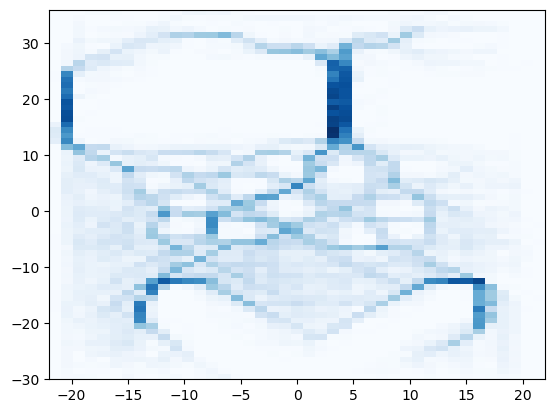

In [5]:
hist = plt.hist2d(positions[:, 0], positions[:, 1], bins=(41, 66), cmap='Blues', range=[[-22, 22], [-30, 36]])

  0%|          | 0/128 [00:00<?, ?it/s]

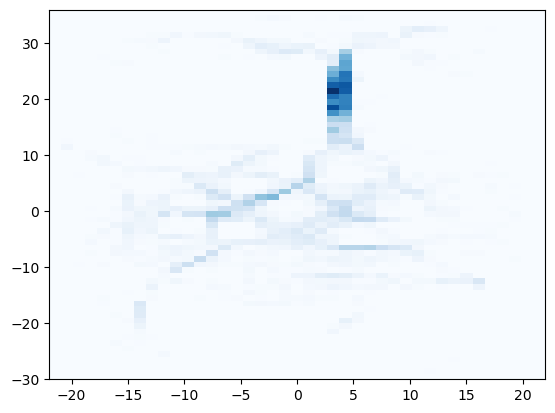

In [7]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

histogram = []
for idx in tqdm(range(128)):
    mean_activations = np.mean(latents, axis=(2, 3))[:, idx]
    units = positions[np.mean(latents, axis=(2, 3))[:, idx] > quant]
    hist = plt.hist2d(units[:, 0], units[:, 1], bins=(41, 66), cmap='Blues', range=[[-22, 22], [-30, 36]])
    histogram.append(hist[0])

histogram = np.stack(histogram, axis=0)

total_hist, xedges, yedges = np.histogram2d(positions[:, 0], positions[:, 1], bins=(41, 66), range=[[-22, 22], [-30, 36]])
total_hist = np.where(total_hist == 0, 1e-10, total_hist)
normalized_histogram = histogram / total_hist
normalized_histogram = np.nan_to_num(normalized_histogram)

  0%|          | 0/128 [00:00<?, ?it/s]

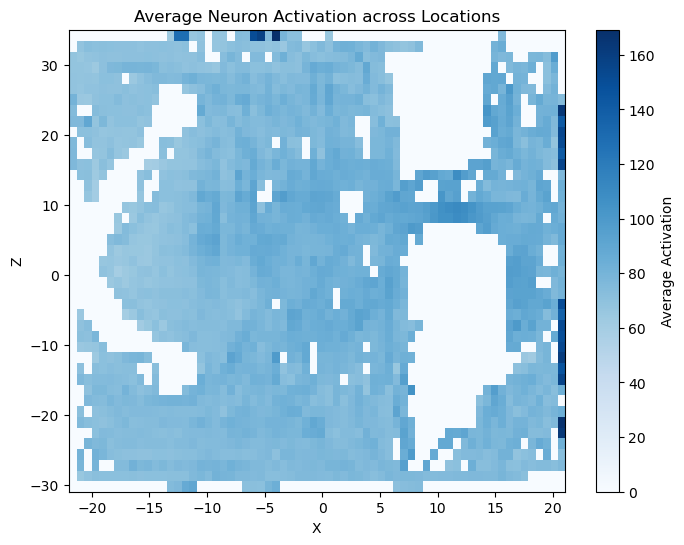

In [31]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

histogram = []

x_bin_size = 1
y_bin_size = 1

def bin_coordinates(coord, x_size, y_size):
    binned_x = np.floor(coord[0] / x_size) * x_size
    binned_y = np.floor(coord[1] / y_size) * y_size
    return binned_x, binned_y

# Apply binning to coordinates
binned_coords = [bin_coordinates(coord, x_bin_size, y_bin_size) for coord in positions[:, :2]]

x_bins, y_bins = zip(*binned_coords)

avg_latent_activations = []

for idx in tqdm(range(128)):
    activations = latents[:, idx]
    location_activations = {}
    for (x, y), activation in zip(binned_coords, activations):
        if (x, y) not in location_activations:
            location_activations[(x, y)] = []
        location_activations[(x, y)].append(activation)

    average_activations = {loc: np.mean(vals) for loc, vals in location_activations.items()}
    avg_latent_activations.append(average_activations)
    x, y, avg_activations = zip(*[(loc[0], loc[1], avg) for loc, avg in average_activations.items()])
    
    heatmap, xedges, yedges = np.histogram2d(x, y, weights=avg_activations, bins=(np.arange(min(x), max(x)+x_bin_size, x_bin_size), np.arange(min(y), max(y)+y_bin_size, y_bin_size)))
    histogram.append(heatmap)

histogram = np.stack(histogram, axis=0)

summed_histogram = np.sum(histogram, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(summed_histogram, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='Blues')
plt.colorbar(label='Average Activation')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Average Neuron Activation across Locations')
plt.show()

In [19]:
heatmap[0][2]

0.0

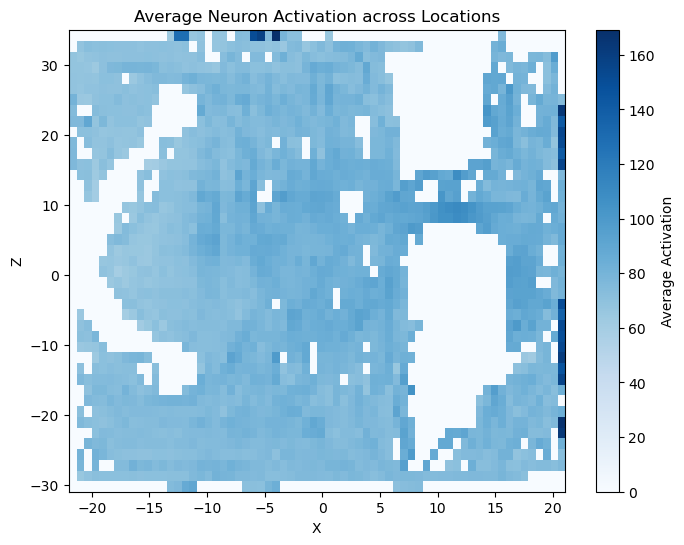

In [39]:
summed_histogram = np.sum(histogram, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(summed_histogram, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='Blues')
plt.colorbar(label='Average Activation')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Average Neuron Activation across Locations')
plt.show()

In [47]:
units_pos = units[:, :2]

weight_factors = 1 / (total_hist + 1e-10) 

def find_bin_index(x, y, xedges, yedges):
    x_idx = np.digitize(x, xedges) - 1 
    y_idx = np.digitize(y, yedges) - 1
    return x_idx, y_idx


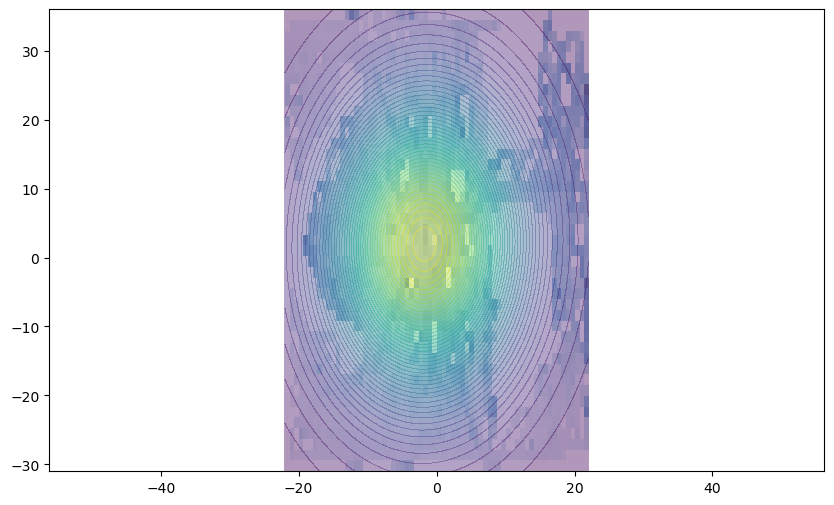

In [61]:
from scipy.spatial import ConvexHull
#fig, axes = plt.subplots(nrows=16, ncols=8, figsize=(20, 40))
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 20))

approx_areas = []
areas = []

bin_size = 0.1

x_bin_size = 1
y_bin_size = 1

def bin_coordinates(coord, x_size, y_size):
    binned_x = np.floor(coord[0] / x_size) * x_size
    binned_y = np.floor(coord[1] / y_size) * y_size
    return binned_x, binned_y

for idx in range(49,50):

    i, j = idx // 8, idx % 8
    ax = axes#[i, j]

    avg_activations = avg_latent_activations[idx]

    activations = latents[:, idx]
    pos_units = positions[:, :2]

    binned_positions = np.array([bin_coordinates(pos, x_bin_size, y_bin_size) for pos in pos_units])
    weights = np.array([avg_activations.get(tuple(pos), 0) for pos in binned_positions])

    #unit_weights = [weight_factors[find_bin_index(x, y, xedges, yedges)] for x, y in pos_units]
    #unit_weights = np.array(unit_weights)

    # weights should be avg activations
    
    weighted_mean = np.average(binned_positions, axis=0, weights=weights)
    weighted_covariance = np.cov(binned_positions.T, aweights=weights)
        
    cov = weighted_covariance#np.cov(pos_units, rowvar=False)
    mu = weighted_mean #pos_units.mean(axis=0).reshape(-1, 1, 1)
    #approx_areas += [np.multiply.reduce(np.sqrt(np.linalg.svd(cov)[1])) * np.pi]
    #areas += [(normalized_histogram[idx] > 0).sum()]

    fig, ax = plt.subplots(figsize=(10, 6))

    # np.arange(min(x), max(x)+x_bin_size, x_bin_size), np.arange(min(y), max(y)+y_bin_size, y_bin_size
    
    # Gaussian distribution plot
    x_range = np.linspace(min(x), max(x)+x_bin_size, 300)
    y_range = np.linspace(min(y), max(y)+y_bin_size, 300)
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.vstack([X.ravel(), Y.ravel()]).T

    dalpha = 0.9
    
    gauss = np.exp(-0.5 * np.sum((grid - weighted_mean) @ np.linalg.inv(weighted_covariance) * (grid - weighted_mean), axis=1))
    gauss = gauss.reshape(X.shape) / (2 * np.pi * np.sqrt(np.linalg.det(weighted_covariance)))

    im = histogram[idx]
    ax.imshow(im, extent=[x_range.min(), x_range.max(), y_range.min(), y_range.max()], origin='lower', cmap="Blues", alpha=0.6)
    #ax.imshow(im, cmap="Blues", alpha=im*dalpha, extent=[-30, 36, 22, -22])
    ax.contourf(X, Y, gauss, levels=50, alpha=0.4, cmap='viridis')
    ax.axis('equal')
    plt.show()



Text(0.5, 9.444444444444438, 'Area (Gaussian approximation, lattice units)')

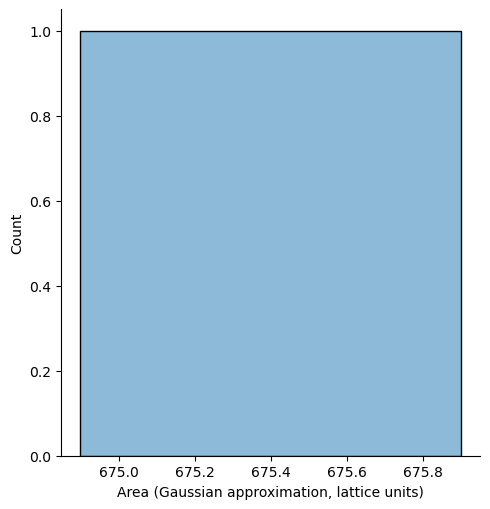

In [61]:
sns.displot(approx_areas, kde=True, fill=True)
plt.xlabel("Area (Gaussian approximation, lattice units)")


Text(0.5, 0, 'Environment block')

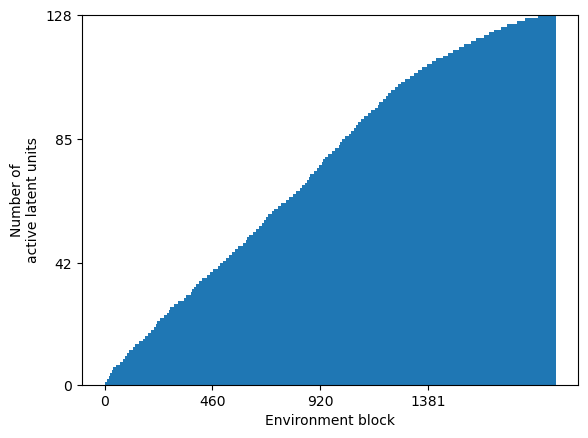

In [45]:
mask = histogram.sum(axis=0) != 0
plt.bar(np.arange(mask.sum()), np.sort((histogram[:, mask] > 0).reshape(128, -1).sum(axis=0)), width=1)
plt.ylim([0, 128])
plt.yticks(np.linspace(0, 128, 4).astype(np.int32))
plt.xticks(np.linspace(0, 1381, 4).astype(np.int32))
plt.ylabel("Number of\nactive latent units")
plt.xlabel("Environment block")


Text(0.5, 0, 'Latent unit')

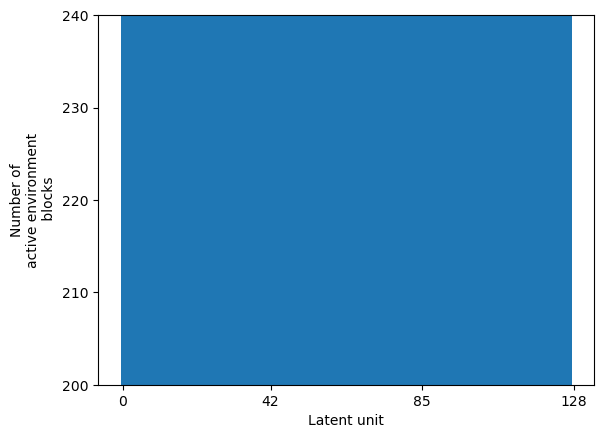

In [46]:
mask = histogram.sum(axis=0) != 0

plt.bar(np.arange(128), np.sort((histogram[:, mask] > 0).reshape(128, -1).sum(axis=1)), width=1)

plt.ylim([200, 240])
plt.yticks(np.linspace(200, 240, 5).astype(np.int32))
plt.xticks(np.linspace(0, 128, 4).astype(np.int32))
plt.ylabel("Number of\nactive environment\n blocks")
plt.xlabel("Latent unit")


  0%|          | 0/128 [00:00<?, ?it/s]

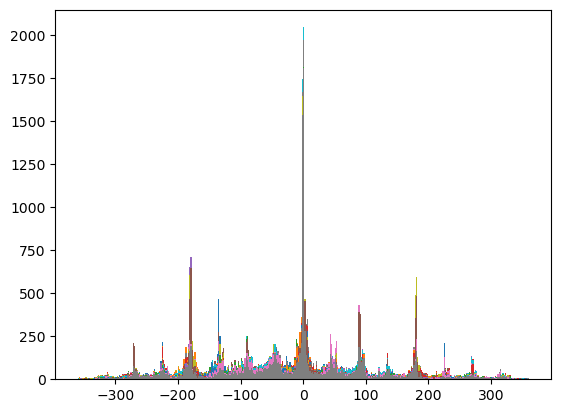

In [76]:
view_histogram = []

for idx in tqdm(range(128)):
    quant = np.quantile(np.mean(latents, axis=(2, 3))[:, idx], 0.85)
    units = positions[np.mean(latents, axis=(2, 3))[:, idx] > quant]
    hist = plt.hist(units[:, 2], bins=(360), range=[-360, 360])
    view_histogram.append(hist[0])

view_histogram = np.stack(view_histogram, axis=0)

total_view_hist, yaw_edges = np.histogram(positions[:, 2], bins=(360), range=[-360, 360])
total_view_hist = np.where(total_view_hist == 0, 1e-10, total_view_hist)
# plt.hist(units[:, 2], bins=(360), range=[-360, 360])
normalized_view_histogram = view_histogram / total_view_hist
normalized_view_histogram = np.nan_to_num(normalized_view_histogram)

44444.37181344145


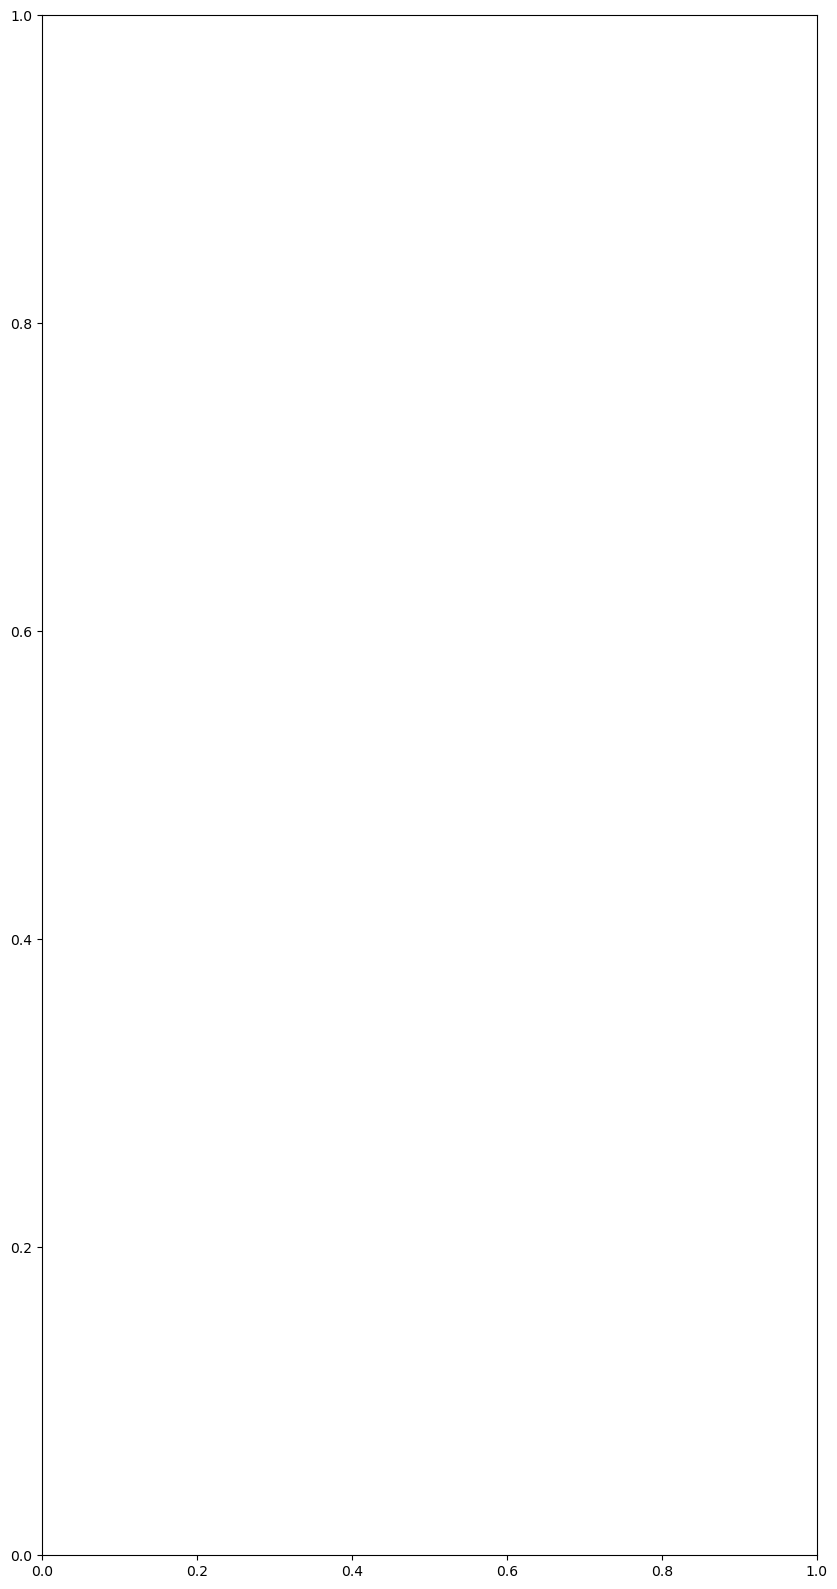

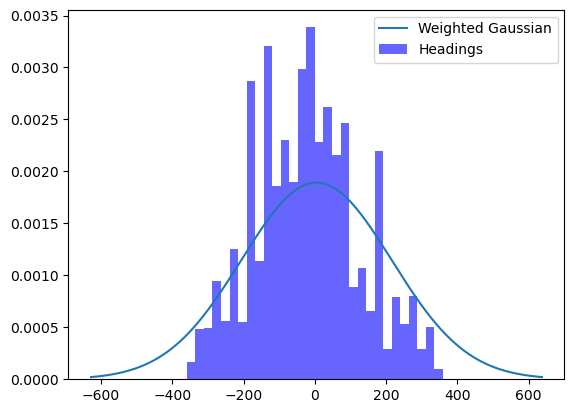

In [103]:
from scipy.spatial import ConvexHull
#fig, axes = plt.subplots(nrows=16, ncols=8, figsize=(20, 40))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 20))

approx_areas = []
areas = []

weight_factors = 1 / (total_view_hist + 1e-10) 

def find_bin_index(yaw, yaw_edges):
    yaw_idx = np.digitize(yaw, yaw_edges) - 1 
    return yaw_idx

for idx in range(71,72):

    i, j = idx // 8, idx % 8
    ax = axes#[i, j]
        
    quant = np.quantile(np.mean(latents, axis=(2, 3))[:, idx], 0.9)
    units = positions[np.mean(latents, axis=(2, 3))[:, idx] > quant]
    pos_units = units[:, 2]

    unit_weights = [weight_factors[find_bin_index(yaw, yaw_edges)] for yaw in pos_units]
    unit_weights = np.array(unit_weights)
    
    weighted_mean = np.average(pos_units, axis=0, weights=unit_weights)#.reshape(-1, 1, 1)
    weighted_covariance = np.cov(pos_units.T, aweights=unit_weights)
        
    cov = weighted_covariance #np.cov(pos_units, rowvar=False)
    print(cov)
    mu = weighted_mean #pos_units.mean(axis=0).reshape(-1, 1, 1)
    #approx_areas += [np.multiply.reduce(np.sqrt(np.linalg.svd(cov))) * np.pi]
    areas += [(normalized_view_histogram[idx] > 0).sum()]

    x_values = np.linspace(weighted_mean - 3*np.sqrt(weighted_covariance), weighted_mean + 3*np.sqrt(weighted_covariance), 400)
    gaussian = (1 / np.sqrt(2 * np.pi * weighted_covariance)) * np.exp(-((x_values - weighted_mean)**2 / (2 * weighted_covariance)))
        
    #grid = np.mgrid[-22:22:0.1]
    
    #gauss = 1/(2*np.pi) * np.linalg.det(cov)**(-0.5) * np.exp(
    #    -0.5 * np.einsum(
    #    "ijk,ijk->jk",
    #    (grid - mu),
    #    np.einsum("ij,jkl", np.linalg.inv(cov), (grid - mu))
    #))
    
    #dalpha = 0.9
    #im = normalized_view_histogram[idx] > 0
    #ax.imshow(im, cmap="Blues", alpha=im*dalpha)
    #thres = np.quantile(gaussian, 0.90)
    #ax.imshow(gaussian, cmap="Blues", alpha=0.6)
    #ax.set_title(f"Normalized Predictive Coder Neuron {idx}")
    #ax.axis("off")

    fig, ax = plt.subplots()
    ax.plot(x_values, gaussian, label='Weighted Gaussian')
    ax.hist(pos_units, bins=30, density=True, alpha=0.6, color='blue', label='Headings')
    ax.legend()
    plt.show()



In [70]:
np.where(yaws > 180)

(array([   30,    31,    32, ..., 14979, 15003, 15004]),)

In [ ]:
# plot the trajectories it follows and head direction per step
# see if models encode objects
# then train model to predict objects instead
# increase blur
# make head direction less predictable/more diffuse
# plotting trajectories

# head dir is gaze instead?

# start with the more random movements then continue on